In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


# ResRNN
Try a recurrent neural network that accumulates implied storages explicitly (doing away with LSTM memory cell). Instead of relying on gates to learn mass balance, we can enforce storage accumulation directly. Potentially comparable performance for much fewer parameters.

## Data Processing
Read Shasta data

In [30]:
def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, 
                    left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False, storage=False):
    """
    Run data processing pipeline.
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, 
                                   chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow, STORAGE, and doy as input features
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [32]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing('Shasta', transform_type='standardize',
                                                                       storage=False)

In [45]:
# Get observed storages
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

# Check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * 0.6))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * 0.2))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

# Get observed storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

## Define New Model

In [36]:
class resRNN(nn.Module):
    """
    Recurrent neural network to model reservoir releases, with internal storage accumulation
    """
    def __init__(self, input_size, hidden_size, output_size, dropout_prob, 
                 initial_output=0, initial_implied_storage=0):
        """
        Params:
        input_size -- # of features in input (EXCLUDING implied storage)
        hidden_size -- # of hidden units in Feedforward
        output_size -- # of features in output
        dropout_prob -- dropout probability for dropout layers
        initial_output -- initialize "previous" output for first timestep
        initial_implied_storage -- initialize "previous" implied storage for first timestep
        """
        super(resRNN, self).__init__()
        self.inital_output = initial_output
        self.initial_implied_storage = initial_implied_storage
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize model layers
        # Get hidden state
        self.linear1 = nn.Linear(input_size + 1 + hidden_size, hidden_size)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(dropout_prob)
        # Get output
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Run the forward pass.
        Params:
        x -- model input of shape (batch size, timesteps, input_size)
        Returns:
        out -- model output of shape (batch size, timesteps, output_size)
        implied_storage -- implied storages of shape (batch size, timestpes, output_size)
        """
        # get dimensions
        N, L, Hin = x.shape # input shape is (batch size, timesteps, input size)

        hidden_states = [] # store sequence of hidden states
        implied_storages = [] # store sequence of implied storages
        output = [] # store predictions

        # initialize previous output (batch size, output size)
        prev_output = self.inital_output * torch.ones((N, self.output_size))
        # initialize previous implied storage (batch size, output size)
        prev_implied_storage = self.initial_implied_storage * torch.ones((N, self.output_size))
        # initialize hidden state
        hx = torch.zeros(N, self.hidden_size) # (batch size, hidden size)

        for i in range(L):
            # calculate current implied storage: prev storage + current inflow - prev output
            current_implied_storage = prev_implied_storage + x[:, i, [0]] - prev_output # (batch size, output size)
            # save current implied storage
            implied_storages.append(current_implied_storage)

            # append previous implied storage and previous hidden state to input of current timestep: 
            # (batch size, input size) -> (batch size, input size + output size + hidden_size)
            input_i = torch.cat([x[:, i, :], current_implied_storage, hx], dim=-1)

            # get current hidden state (FF layer)
            hx = self.tanh1(self.linear1(input_i)) # (batch size, hidden_size)
            hidden_states.append(hx) # save hidden state for current timestep

            # get output (linear head)
            out = self.dropout1(hx) # (batch size, hidden size)
            out = self.linear2(out) # (batch size, output size)

            # save results, update prev_output and prev_implied_storage for next timestep
            output.append(out)
            prev_output = out
            prev_implied_storage = current_implied_storage
    
        # concatenate results along new dimension (create timesteps dimension at dim=1)
        hidden_states = torch.stack(hidden_states, dim=1) # (batch size, timesteps, hidden size)
        implied_storages = torch.stack(implied_storages, dim=1) # (batch, timesteps, output size)
        output = torch.stack(output, dim=1) # (batch size, timesteps, output size)

        return output, implied_storages

## Train New Model

In [37]:
# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

In [38]:
# Instantiate model
input_size = 2
hidden_size = 30
output_size = 1
dropout_prob = 0.3
torch.manual_seed(0)
model = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
               dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Run training loop
train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

Training epochs:   9%|▉         | 94/1000 [14:30<2:19:49,  9.26s/it]


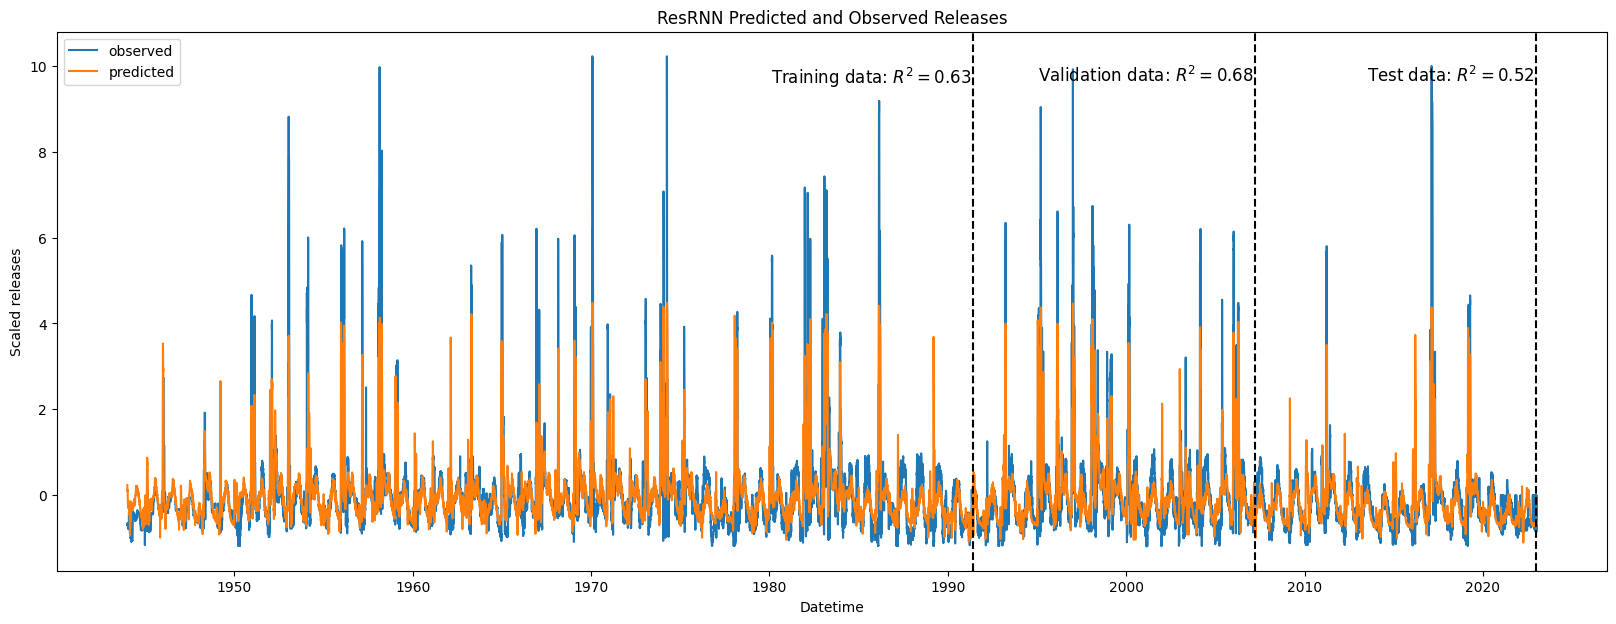

In [50]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval(model=model, X_train=X_train, X_val=X_val, X_test=X_test,
              y_train=y_train, y_val=y_val, y_test=y_test,
              datetime_index=pd.date_range(start='1944-01-01', end='2022-12-31', freq='D'),
              text_ypos=10, ax=ax)
plt.title('ResRNN Predicted and Observed Releases')
plt.savefig('report/drafting/2_27_2024/figures/ResRNN_observed_predicted.png', dpi=300)
plt.show()

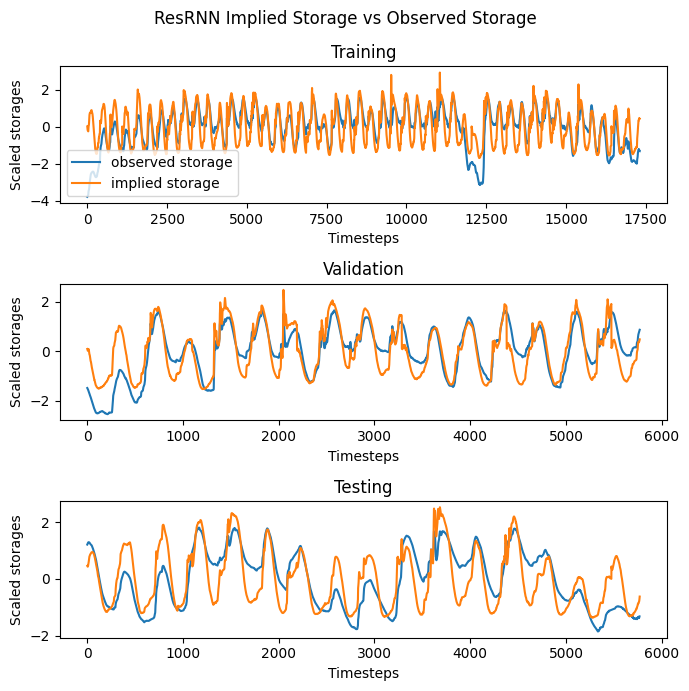

In [48]:
# Plot implied storages, shape is (# chunks, timesteps, hidden size)
from src.models.analyze_lstm_cell import plot_storage_cell
with torch.no_grad():
    model.eval()
    im_storage_train = model(X_train)[1].detach()
    im_storage_val = model(X_val)[1].detach()
    im_storage_test = model(X_test)[1].detach()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))
plot_storage_cell(cell_states_all=im_storage_train, storage_states=storage_train, cell_id=0, ax=axes[0])
axes[0].legend(['observed storage', 'implied storage'], loc='lower left')
axes[0].set_title('Training')
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('Scaled storages')

plot_storage_cell(cell_states_all=im_storage_val, storage_states=storage_val, cell_id=0, ax=axes[1])
axes[1].set_title('Validation')
axes[1].set_xlabel('Timesteps')
axes[1].set_ylabel('Scaled storages')

plot_storage_cell(cell_states_all=im_storage_test, storage_states=storage_test, cell_id=0, ax=axes[2])
axes[2].set_title('Testing')
axes[2].set_xlabel('Timesteps')
axes[2].set_ylabel('Scaled storages')

fig.suptitle('ResRNN Implied Storage vs Observed Storage')
plt.tight_layout()
plt.savefig('report/drafting/2_27_2024/figures/ResRNN_implied_storage.png', dpi=300)
plt.show()

## Number of Parameters

In [51]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            params = parameter.numel()
            total_params += params
    return total_params

In [52]:
count_parameters(model)

1051